In [1]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm

# check likelihood 

simulate

In [10]:
v = 1; a = 5
N_sim = int(1000)
dt = 1e-4
dB = np.sqrt(dt)

RTs = np.zeros(N_sim)


def simulate(v,a,dt,dB):
    DV = 0; t = 0
    while True:
        DV += v*dt + np.random.normal(0, dB)
        t += dt

        if DV >= a:
            return t
            
sim_results = Parallel(n_jobs=-1)(delayed(simulate)(v,a,dt,dB) for _ in tqdm(range(N_sim)))

100%|██████████| 1000/1000 [00:00<00:00, 1561.33it/s]


likelihod func

In [7]:
def rho_A_t_fn(t, V_A, theta_A):
    """
    For AI,prob density of t given V_A, theta_A
    """
    if t <= 0:
        return 0
    return (theta_A*1/np.sqrt(2*np.pi*(t)**3))*np.exp(-0.5 * (V_A**2) * (((t) - (theta_A/V_A))**2)/(t))


compare

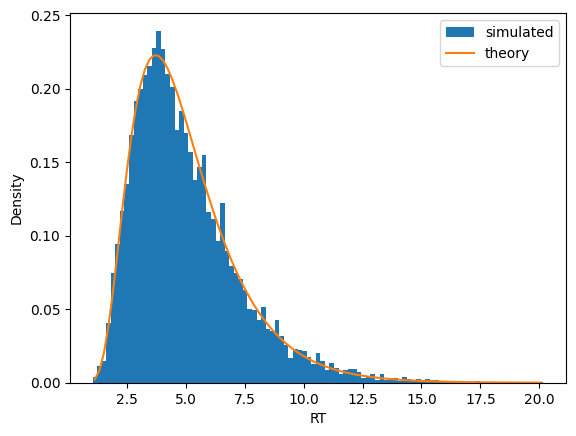

In [8]:
bins = np.linspace(min(sim_results), max(sim_results), 100)
plt.hist(sim_results, bins=bins, density=True, label='simulated')

t_pts = bins[:-1] + np.diff(bins)/2
theory = [rho_A_t_fn(t, v, a) for t in t_pts]
plt.plot(t_pts, theory, label='theory')

plt.xlabel('RT')
plt.ylabel('Density')
plt.legend();

# neural network

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim


In [12]:
class RT_single_bound_net(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RT_single_bound_net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, 2)  # Output layer now produces two outputs
        self.softplus = nn.Softplus()  # Activation to ensure outputs are positive

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.softplus(out)  # Apply Softplus activation
        return out  # Returns two positive numbers

# inputs and outputs shape

In [14]:
# Initialize the model
input_size = 2    # Number of input features
hidden_size = 50   # Number of neurons in the hidden layer
model = RT_single_bound_net(input_size, hidden_size)

# Create some sample input data
batch_size = 4
sample_input = torch.randn(batch_size, input_size)  # Random input tensor

# Pass the input through the model
output = model(sample_input)

print(output.shape)

torch.Size([4, 2])


In [ ]:
v_min = 1; v_max = 5
a_min = 0.1; a_max = 5

batch_size = 4
v_samples = torch.tensor(np.random.uniform(v_min, v_max, batch_size)).float()
a_samples = torch.tensor(np.random.uniform(a_min, a_max, batch_size)).float()

print(v_samples, a_samples, v_samples.shape, a_samples.shape)

sim_results_all_batch = np.zeros((batch_size, N_sim))
for i in range(batch_size):
    sim_results_all_batch[i, :] = Parallel(n_jobs=-1)(delayed(simulate)(v_samples[i].item(), a_samples[i].item(), dt, dB) for _ in range(N_sim))


tensor([4.3290, 1.8690, 4.6039, 4.4362]) tensor([2.1158, 4.7376, 1.6085, 2.6203]) torch.Size([4]) torch.Size([4])


In [38]:
sim_results_all_batch.shape
# convert to tensor
sim_results_all_batch_tensor = torch.tensor(sim_results_all_batch).float()

# loss

In [116]:
def nll_func(_lambda, nu, rt_batch_N_sim):
    # _lambda: Tensor of shape [batch_size]
    # nu: Tensor of shape [batch_size]
    # rt_batch_N_sim: Tensor of shape [batch_size, N_sim_size]
    
    # Ensure no zero or negative values to prevent numerical issues
    eps = 1e-6
    _lambda = _lambda + eps  # Shape: [batch_size]
    nu = nu + eps            # Shape: [batch_size]
    
    # Expand _lambda and nu to match the dimensions of rt_batch_N_sim
    _lambda = _lambda.unsqueeze(1)  # Shape: [batch_size, 1]
    nu = nu.unsqueeze(1)            # Shape: [batch_size, 1]
    
    # Compute the Negative Log-Likelihood (NLL) per reaction time
    term1 = 0.5 * torch.log(2 * torch.pi * rt_batch_N_sim**3 / _lambda)
    term2 = (_lambda * (rt_batch_N_sim - nu)**2) / (2 * (nu**2) * rt_batch_N_sim)
    NLL = term1 + term2  # Shape: [batch_size, N_sim_size]
    
    # Aggregate NLL over reaction times for each batch element
    NLL_per_batch = NLL.mean(dim=1)  # Shape: [batch_size]
    # Compute the mean NLL over the batch
    NLL_mean = NLL_per_batch.mean()  # Scalar value
    
    return NLL_mean


# live loss plot

In [117]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

def live_plot(all_loss_arr, title, figsize=(7,5)):
    clear_output(wait=True)
    plt.figure(figsize=figsize)
    plt.plot(np.arange(1, len(all_loss_arr)+1), all_loss_arr)
    plt.xlabel('epoch')
    plt.title(title)
    plt.show()

# train

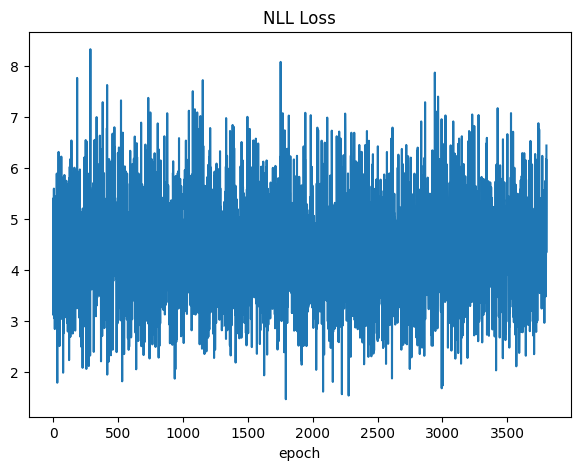

KeyboardInterrupt: 

In [125]:
input_size = 2
hidden_size = 50

batch_size = 16
model = RT_single_bound_net(input_size, hidden_size)

N_epochs = int(10e3)

# Define the optimizer
learning_rate = 1e-2
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

model = RT_single_bound_net(input_size, hidden_size)

v_min = 1; v_max = 5
a_min = 0.1; a_max = 5
dt = 1e-3; N_sim = 1000; dB = np.sqrt(dt); N_sim = 500
all_loss = []

for n in range(N_epochs):
    v_samples = torch.tensor(np.random.uniform(v_min, v_max, batch_size)).float()
    a_samples = torch.tensor(np.random.uniform(a_min, a_max, batch_size)).float()

    sim_results_all_batch = np.zeros((batch_size, N_sim))
    for i in range(batch_size):
        sim_results_all_batch[i, :] = Parallel(n_jobs=-1)(delayed(simulate)(v_samples[i].item(), a_samples[i].item(), dt, dB) for _ in range(N_sim))

    
    sim_results_all_batch_tensor = torch.tensor(sim_results_all_batch).float()

    # Forward pass
    output = model(torch.stack([v_samples, a_samples], dim=1))

    # Compute the Negative Log-Likelihood (NLL)
    loss = nll_func(output[:, 0], output[:, 1], sim_results_all_batch_tensor)

    # Zero the gradients
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    all_loss.append(loss.item())

    if n % 25 == 0 and n != 0:
        live_plot(all_loss, 'NLL Loss')

print('Final loss:', all_loss[-1])





